In [ ]:
!pip install scikit-learn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from IPython.display import clear_output

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes.'.format(name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jarvisgroot/brain-tumor-classification-mri-images
!unzip brain-tumor-classification-mri-images.zip
clear_output()

In [3]:
data_path = '/content/brain_tumor_mri/new_dataset/bt_images'

training_data_path = os.path.join(data_path, '/content/brain_tumor_mri/new_dataset/training_data.pickle')
labels_path = os.path.join(data_path, '/content/brain_tumor_mri/new_dataset/labels.pickle')
test_data_path = os.path.join(data_path, '/content/test_images-20210704T210303Z-001/test_images')

with open(training_data_path, 'rb') as training_data_file:
    training_data = pickle.load(training_data_file)

with open(labels_path, 'rb') as labels_file:
    labels = pickle.load(labels_file)

In [4]:
image_path = '/content/brain_tumor_mri/new_dataset/bt_images/1.jpg'
img = Image.open(image_path)

width, height = img.size

print("Image Width:", width)
print("Image Hieght:", height)

Image Width: 512
Image Hieght: 512


In [5]:
training_data = np.array(training_data)
labels = np.array(labels)

<ipython-input-5-02aadbb422b2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_data = np.array(training_data)


In [6]:
adjusted_labels = labels - 1
unique_labels = np.unique(adjusted_labels)
print(unique_labels)

[0 1 2]


In [8]:
file_list = os.listdir(data_path)
image_files = [file for file in file_list if file.lower().endswith(('.jpg', '.png', 'jpeg'))]

print(image_files[0])

image_data = []

for image_file in image_files:
  image_path = os.path.join(data_path, image_file)
  img = Image.open(image_path)

  img = img.convert('RGB')
  img = img.resize((224, 224))
  img_array = np.array(img)

  image_data.append(img_array)

images_array = np.array(image_data)
del image_data

250.jpg


In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images_array, adjusted_labels, test_size=0.2, random_state=42)

In [ ]:
num_classes = len(np.unique(adjusted_labels))
train_labels_categorical = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

In [ ]:
train_images.shape

(2451, 224, 224, 3)

In [ ]:
model = Sequential()

# pretrained_model = tf.keras.applications.ResNet50V2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224, 224, 3),
#     pooling=None,
#     classes=3,
#     classifier_activation="softmax",
# )

# pretrained_model = tf.keras.applications.ResNet152V2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224, 224, 3),
#     pooling=None,
#     classes=3,
#     classifier_activation="softmax",
# )

pretrained_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=3,
    classifier_activation="softmax",
)


for layer in pretrained_model.layers:
  layer.trainable=False

model.add(pretrained_model)
# model.add(tf.keras.Conv2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

batch_size = 32
epochs = 10

history = model.fit(
    train_images,
    train_labels_categorical,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (test_images, test_labels_categorical)
)

Epoch 1/10
77/77 [==============================] - 31s 150ms/step - loss: 5.7078 - accuracy: 0.3562 - val_loss: 8.7370 - val_accuracy: 0.3214
Epoch 2/10
77/77 [==============================] - 7s 94ms/step - loss: 3.2522 - accuracy: 0.5402 - val_loss: 5.7998 - val_accuracy: 0.3752
Epoch 3/10
77/77 [==============================] - 7s 94ms/step - loss: 2.0814 - accuracy: 0.6605 - val_loss: 5.6362 - val_accuracy: 0.3883
Epoch 4/10
77/77 [==============================] - 7s 96ms/step - loss: 1.1393 - accuracy: 0.7723 - val_loss: 6.2781 - val_accuracy: 0.3524
Epoch 5/10
77/77 [==============================] - 9s 114ms/step - loss: 1.0573 - accuracy: 0.7948 - val_loss: 6.3441 - val_accuracy: 0.3850
Epoch 6/10
77/77 [==============================] - 9s 114ms/step - loss: 0.9248 - accuracy: 0.8201 - val_loss: 6.1590 - val_accuracy: 0.3622
Epoch 7/10
77/77 [==============================] - 9s 116ms/step - loss: 0.6937 - accuracy: 0.8531 - val_loss: 7.1149 - val_accuracy: 0.3589
Epoch 8/

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical, verbose=2)
print("Test accuracy:", test_accuracy)

20/20 - 1s - loss: 7.2426 - accuracy: 0.3638 - 1s/epoch - 67ms/step
Test accuracy: 0.36378467082977295


In [ ]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels_categorical, axis=1)

confusion = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(confusion)

20/20 [==============================] - 3s 71ms/step
Confusion Matrix:
[[ 39  87  35]
 [ 67 137  65]
 [ 51  85  47]]


In [ ]:
predictions = model.predict(test_images)

true_labels = test_labels_categorical[:, 1]

auc = roc_auc_score(true_labels, predictions[:, 1])

print("AUC:", auc)
print("Test accuracy:", test_accuracy)

20/20 [==============================] - 1s 67ms/step
AUC: 0.489339284170485
Test accuracy: 0.36378467082977295


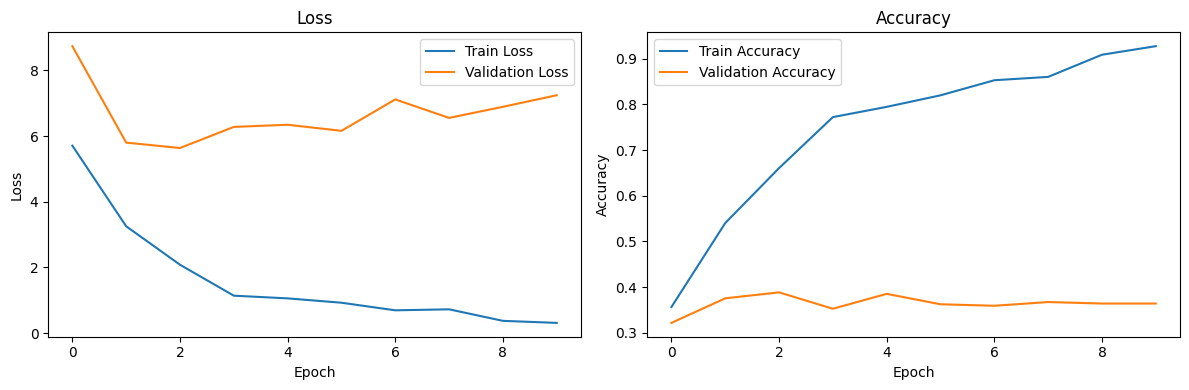

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(test_images)

true_labels = np.argmax(test_labels_categorical, axis=1)

class_names = ["Pituitary", "Meningioma", "Glioma"]
report = classification_report(
    true_labels,
    np.argmax(predictions, axis=1),
    target_names=class_names
)

print("Classification report:\n", report)

20/20 [==============================] - 1s 66ms/step
Classification report:
               precision    recall  f1-score   support

   Pituitary       0.25      0.24      0.25       161
  Meningioma       0.44      0.51      0.47       269
      Glioma       0.32      0.26      0.28       183

    accuracy                           0.36       613
   macro avg       0.34      0.34      0.33       613
weighted avg       0.36      0.36      0.36       613



In [ ]:

max_probabilities = np.max(predictions, axis=1)

for i in range(len(max_probabilities)):
  print(f"Test Image {i + 1} - Confidense: {max_probabilities[i]:.4f}")

Test Image 1 - Confidense: 1.0000
Test Image 2 - Confidense: 0.7301
Test Image 3 - Confidense: 0.9960
Test Image 4 - Confidense: 0.8874
Test Image 5 - Confidense: 1.0000
Test Image 6 - Confidense: 1.0000
Test Image 7 - Confidense: 1.0000
Test Image 8 - Confidense: 1.0000
Test Image 9 - Confidense: 1.0000
Test Image 10 - Confidense: 1.0000
Test Image 11 - Confidense: 0.9977
Test Image 12 - Confidense: 0.9589
Test Image 13 - Confidense: 0.9248
Test Image 14 - Confidense: 0.9134
Test Image 15 - Confidense: 0.9999
Test Image 16 - Confidense: 0.9942
Test Image 17 - Confidense: 1.0000
Test Image 18 - Confidense: 1.0000
Test Image 19 - Confidense: 0.8508
Test Image 20 - Confidense: 0.8659
Test Image 21 - Confidense: 0.7045
Test Image 22 - Confidense: 1.0000
Test Image 23 - Confidense: 0.9998
Test Image 24 - Confidense: 1.0000
Test Image 25 - Confidense: 0.9572
Test Image 26 - Confidense: 0.6895
Test Image 27 - Confidense: 0.9618
Test Image 28 - Confidense: 0.9966
Test Image 29 - Confidense: 0